# Simple Example
With tributary we can easily construct a lazily evaluated graph.

In [1]:
import tributary.lazy as tl

In [2]:
a = tl.Node(value=5)
b = a + 2
c = b % 4

To evaluate the value of the nodes, simply execute them

In [3]:
c()

3

To inspect the dependency graph, we can utilize the `graphviz` method

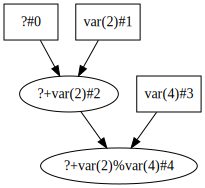

In [4]:
c.graphviz()

If we modify the value of a node, we can see the graph's dirty nodes in red

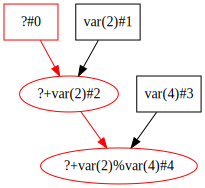

In [5]:
a.setValue(2)
c.graphviz()

c will retain its old value until reexecuted

In [6]:
c.value()

3

In [7]:
c()

0

In [8]:
c.value()

0

# Functions
We can utilize the full library of mathematical functions built into tributary

In [9]:
from random import random
a = tl.Node(name='a', callable=lambda: random(), always_dirty=True) + tl.Cos(a)
b = tl.Sin(a) * tl.Abs(tl.Node(name='anon', value=2))
c = b * tl.Node(name='anon2', value=10)
c()

-6.7891874833358825

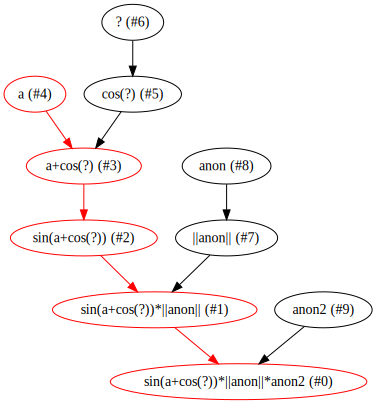

In [10]:
c.graphviz()

# Symbolic - Simple Example
Using tributary's sympy functionality, we can construct relatively complicated graphs. Here we will construct as simple lazy graph

In [11]:
import tributary.symbolic as ts
import tributary.lazy as tl

# Parse sympy expression
expr = ts.parse_expression("10sin**2 x**2 + 3xyz + tan theta")

# Generate a new class representing the graph
clz = ts.construct_lazy(expr)


# A function to use as an input
def func(*args):
    for _ in range(5):
        yield _

# Construct with inputs
x = clz(x=tl.Node(value=1), y=tl.Node(callable=func, always_dirty=True), z=tl.Node(value=1), theta=tl.Node(value=4))

In [12]:
# print value
x.evaluate()()

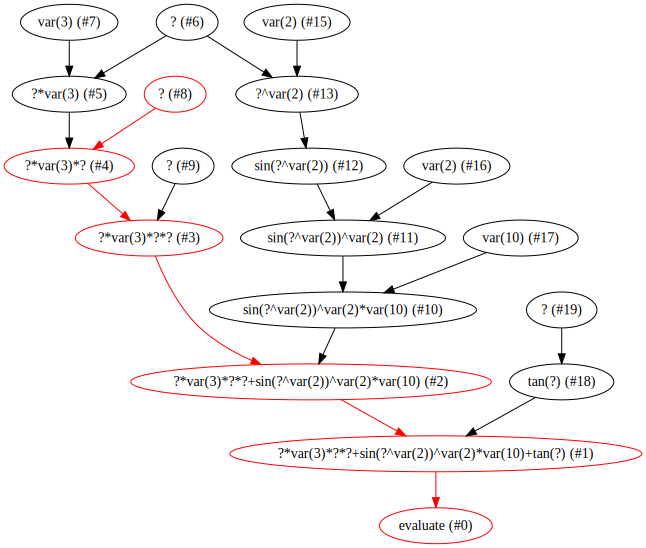

In [13]:
# View the graph
x.evaluate().graphviz()

# Symbolic - More Complicated Example
Here we will construct a lazy pricer for a vanilla european option

In [14]:
import numpy as np
import sympy as sy
from IPython.display import display, HTML
from sympy.stats import Normal as syNormal, cdf
sy.init_printing()

# adapted from https://gist.github.com/raddy/bd0e977dc8437a4f8276
#spot, strike, vol, days till expiry, interest rate, call or put (1,-1)
spot, strike, vol, dte, rate, cp = sy.symbols('spot strike vol dte rate cp')

T = dte / 260.
N = syNormal('N', 0.0, 1.0)

d1 = (sy.ln(spot / strike) + (0.5 * vol ** 2) * T) / (vol * sy.sqrt(T))
d2 = d1 - vol * sy.sqrt(T)

TimeValueExpr = sy.exp(-rate * T) * (cp * spot * cdf(N)(cp * d1) - cp * strike  * cdf(N)(cp * d2))

Let's take a look at the sympy expression


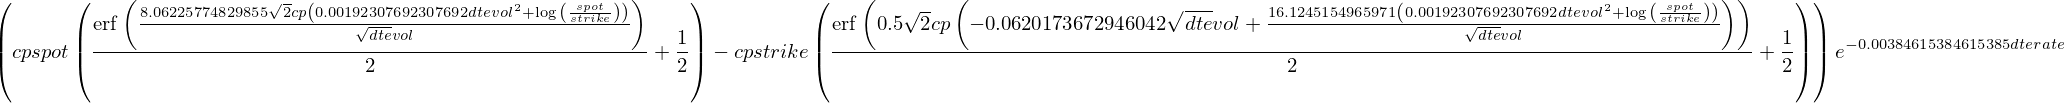

In [15]:
TimeValueExpr

Now using tributary, we construct a lazily-evaluated graph


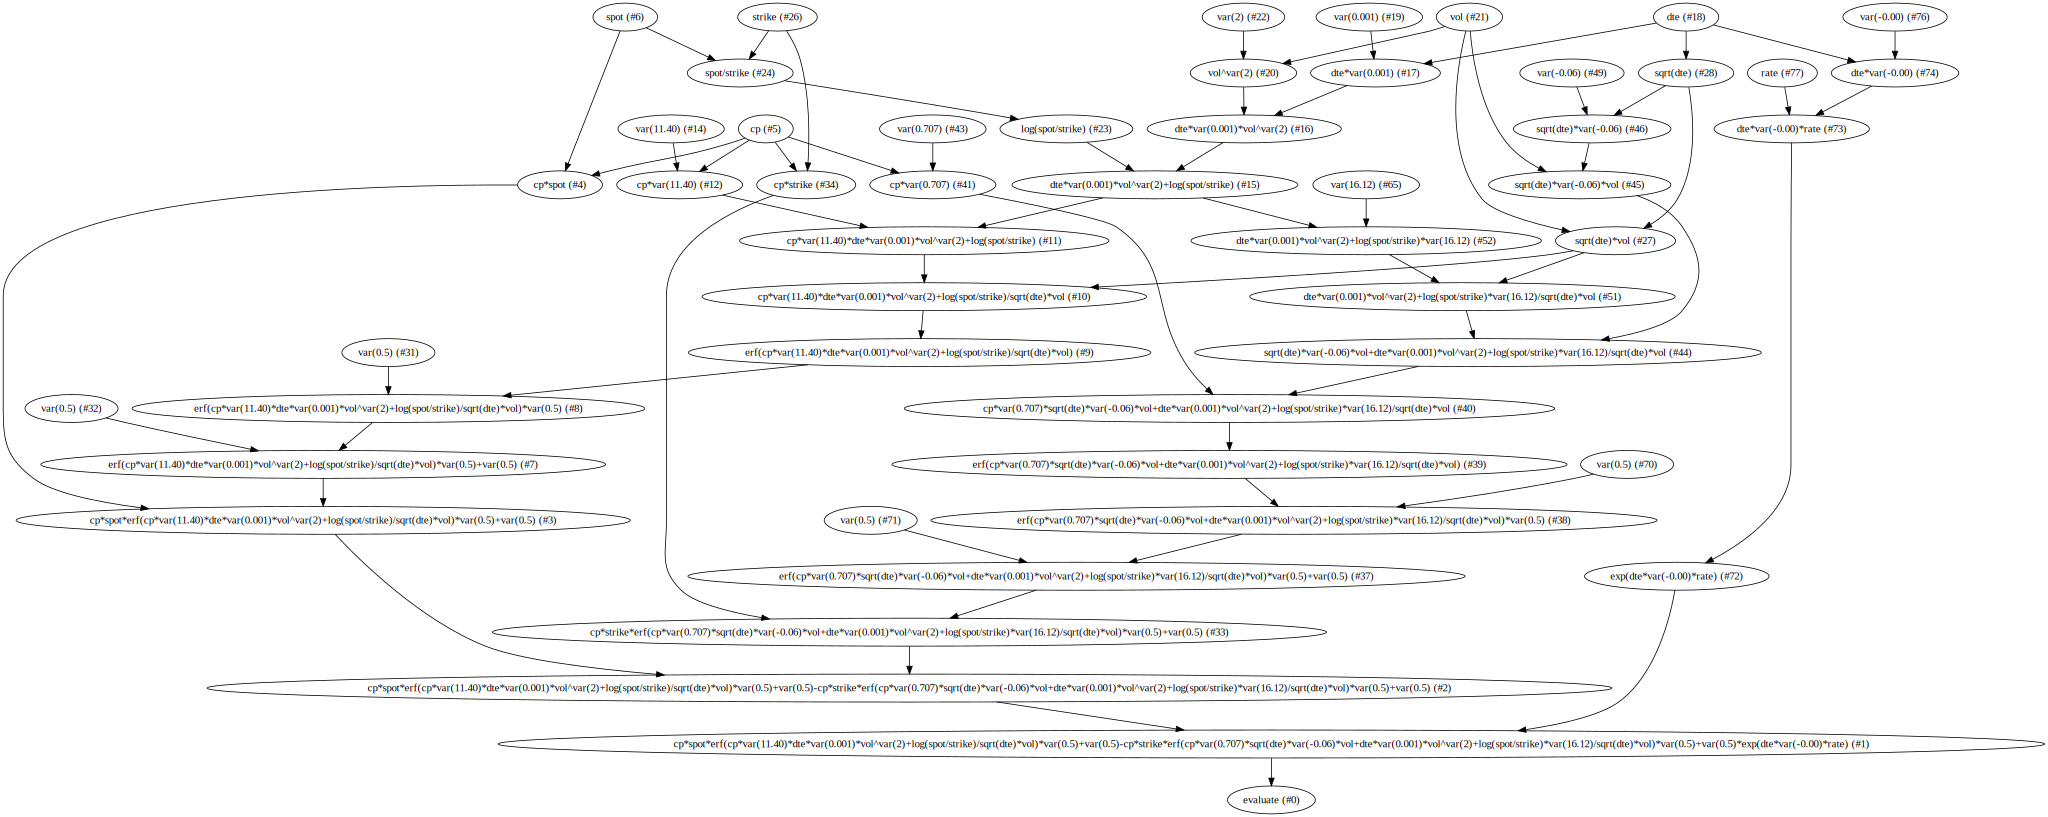

In [16]:
import tributary.symbolic as ts
PriceClass = ts.construct_lazy(TimeValueExpr)

price = PriceClass(spot=210.59, strike=205, vol=14.04, dte=4, rate=.2175, cp=-1)

price.evaluate()()  # 124.819

price.strike = 210
price.evaluate()()  # 124.032

price.evaluate().graphviz()


If we adjust an input, we can see the nodes that will be recalculated on next evaluation


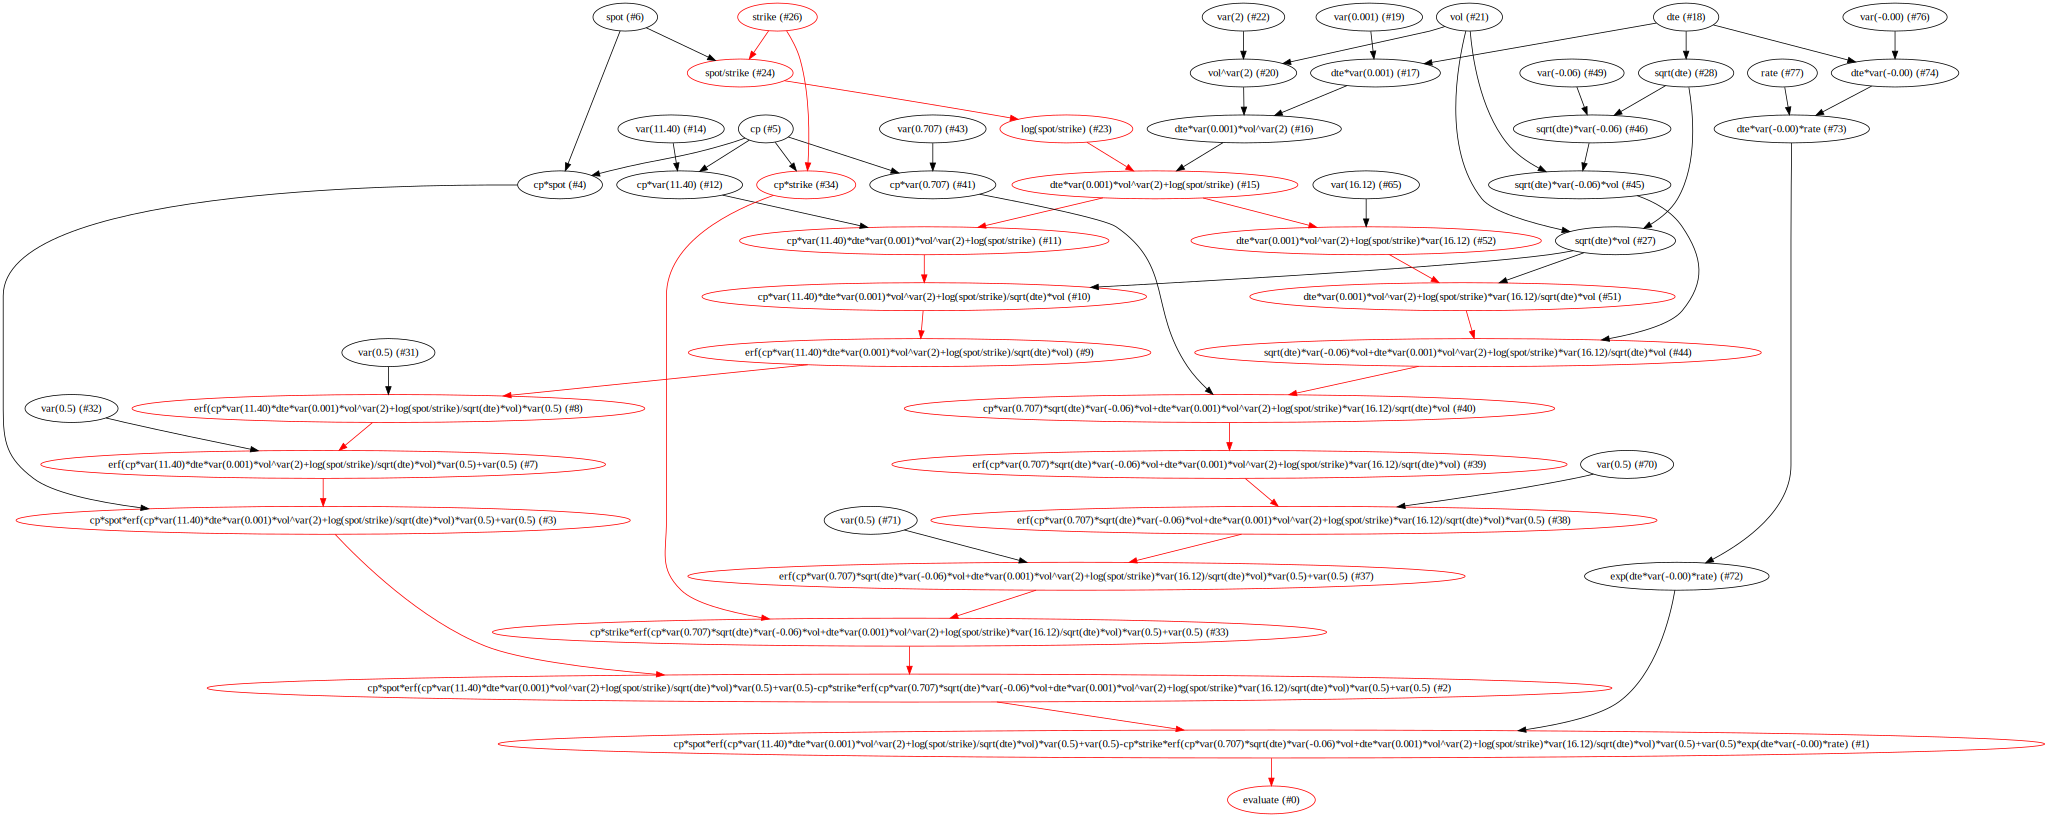

In [17]:
price.strike = 205
price.evaluate().graphviz()
